<h1 style="text-align:center;font-size:40px;">Tools 1 Final Project</h1>
<br>
<br>
<br>
<br>
<p style="text-align:center;">Anthony Molieri<br>
Leo Walker</p>
<br>
<br>
<br>
<br>

The github repository for this project can be found here: https://github.com/molieriAC/DSTools1_FinalProject

# Dataset

The data used for these analyses were scraped from Indeed and Glassdoor. The data from Indeed contains job descriptions for open Data Scientist positions. The Glassdoor data includes employee generated ratings on benefits and perks for many of the companies present in the Indeed dataset. The datasets were then combined in order to give an idea of how employees rank the benefits at these companies.

The Indeed data was scraped searching for5 positions (Data Scientists, Machine Learning Engineer, Data Analyst, BI Analyst, and Data Engineer) from 25 “tech” cities (Atlanta, GA, Austin, TX, Boston, MA, Chicago, IL, Denver, CO, Dallas-Ft. Worth, TX, Los Angeles, CA, NYC, NY, San Francisco, CA, Seattle, WA, Phoenix, AZ, Salt Lake City, UT, San Antonio, TX, San Diego, CA, Jacksonville, FL, Columbus, OH, Boise, ID, Washington DC, Portland, OR, Kansas City, Raleigh, NC, Boulder, CO, Miami, FL, Northern Virginia, Orlando, FL).

The Glassdoor scraper was designed to pull company names from the the job description dataset. It then looped over the list of employers, searched, and scraped ratings from the benefits page for companies that were found. This data was then added to it's own table in the same database. The scraper was designed to be run multiple times, only searching for benefits ratings that were not already present in the database. 

# Motivation
 
Get job descriptions and meta data of popular data related jobs to see how they relate to one another and get insights using their metadata.

To help give a better idea of how employees at companies with open positions rate their benefits other than salary.


# Data Cleaning

In [1]:
# imports
# reading the data
import sqlite3

# data manipulation libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import seaborn as sns
import re

# nltk
import nltk

nltk.download("stopwords")
nltk.download('punkt')

from nltk.corpus import stopwords

stoplist = stopwords.words("english")
from nltk.stem import WordNetLemmatizer

wordnet_lemmatizer = WordNetLemmatizer()
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches
import warnings

warnings.filterwarnings("ignore")

# Enable logging
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\leowa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\leowa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Initialize both tables
cnct = sqlite3.connect("Data/jobs")

indeed_df = pd.read_sql_query("SELECT * FROM indeed_jobs;", cnct)

glassdoor_df = pd.read_sql_query(
    "SELECT companies, type, rating, count_of_ratings FROM ratings;", cnct
)


## Cleaning Indeed Data

In [3]:
# While we were able to get the estimated salary from the job scraping we can see if there was any job salaries within the job description
def salary_extract(row):
    if row["est_salary"] != "No Estimated Salary":
        return row["est_salary"]
    else:
        pattern = r"\$([0-9]{5,6}|[0-9]{2,3},[0-9]{3})"
        found = re.findall(pattern, row["job_desc"])
        if len(found) == 1:
            return f"{found[0]} a year"
        elif len(found) > 1:
            return f"{found[0]} - {found[1]} a year"
        else:
            return None


indeed_df["salary_extract"] = indeed_df.apply(salary_extract, axis=1)


In [4]:
# While we have the job title we need to categorize each job
def set_job_category(job_title):
    regex = re.compile("[^a-zA-Z]")
    clean_title = regex.sub("", job_title)
    clean_title = clean_title.lower()
    if all(x in clean_title for x in ["data", "scien"]):
        return "Data Scientist"
    elif all(x in clean_title for x in ["business", "analy"]):
        return "Business Intelligence Analyst"
    elif all(x in clean_title for x in ["bi", "analy"]):
        return "Business Intelligence Analyst"
    elif all(x in clean_title for x in ["data", "analy"]):
        return "Data Analyst"
    elif all(x in clean_title for x in ["machine", "learning"]):
        return "Machine Learning Engineer"
    elif all(x in clean_title for x in ["data", "engineer"]):
        return "Data Engineer"
    elif all(x in clean_title for x in ["software", "engin"]):
        return "Software Engineer"
    elif all(x in clean_title for x in ["architect"]):
        return "Data Architect"
    else:
        return "Other"


indeed_df["job_category"] = indeed_df.loc[:, "job_title"].apply(set_job_category)


In [5]:
# Lets get the state from the company location so we can generalize them
indeed_df.loc[:, "state"] = indeed_df.loc[:, "company_location"].str.extract(
    r", ([A-Z]{2})"
)


In [6]:
# We have the estimated salary but we need to parse out the min/low and max/high of the salary range so we can determine the average


def salary_low(row):
    if row == None:
        return None
    salary = str(row).split("-")
    pattern = r"([0-9]+\.*,*[0-9]+)"
    low = float("".join(re.findall(pattern, salary[0])).replace(",", ""))
    return low


def salary_high(row):
    if row == None:
        return None
    salary = str(row).split("-")
    pattern = r"([0-9]+\.*,*[0-9]+)"
    if len(salary) > 1:
        high = float("".join(re.findall(pattern, salary[1])).replace(",", ""))
    else:
        high = float("".join(re.findall(pattern, salary[0])).replace(",", ""))
    return high


indeed_df.loc[:, ["salary_low"]] = indeed_df.loc[:, "salary_extract"].apply(salary_low)
indeed_df.loc[:, ["salary_high"]] = indeed_df.loc[:, "salary_extract"].apply(
    salary_high
)


In [7]:
# We noticed that the pay rate varies between annual, month, week, day, or hour.
def pay_rate(row):
    if row == None:
        return None
    regex = re.compile("[.[0-9]]")
    clean_salary = regex.sub("", row)
    clean_salary = clean_salary.lower()
    if any(x in clean_salary for x in ["year"]):
        return "annual"
    elif any(x in clean_salary for x in ["month"]):
        return "month"
    elif any(x in clean_salary for x in ["week"]):
        return "week"
    elif any(x in clean_salary for x in ["day"]):
        return "day"
    elif any(x in clean_salary for x in ["hour"]):
        return "hour"
    else:
        return "Other"


indeed_df["pay_rate"] = indeed_df.loc[:, "salary_extract"].apply(pay_rate)


In [8]:
def calc_salary(row):
    # print(row)
    pay_rate = row["pay_rate"]
    if (pay_rate == "Other") or (pay_rate == None):
        return None

    rate_change = {"annual": 1, "month": 12, "week": 52, "day": 260, "hour": 2080}
    est_annual_salary = ((row["salary_low"] + row["salary_high"]) / 2) * rate_change[
        pay_rate
    ]
    return est_annual_salary


indeed_df["est_annual_salary"] = indeed_df.loc[
    :, ["salary_low", "salary_high", "pay_rate"]
].apply(calc_salary, axis=1)


In [9]:
indeed_df[indeed_df["est_salary"] != "No Estimated Salary"].sample(4)


,index,job_title,company_name,company_location,est salary,job_href,job_desc,est_salary,retrieve_date,salary_extract,job_category,state,salary_low,salary_high,pay_rate,est_annual_salary
2129,4,Sr. Data Engineer,Xcel Energy,"Denver, CO 80202 (Union Station area)",None,https://www.indeed.com/rc/clk?jk=40ce8898128a7...,The Digital Ops Factory Data Engineer will wor...,"$100,000 - $142,000 a year",2022-02-12,"$100,000 - $142,000 a year",Data Engineer,CO,100000.0,142000.0,annual,121000.0
16318,12,Dynamics 365 Data Analyst,Arthur Grand Technologies Inc,"Remote in Austin, TX",None,https://www.indeed.com/company/Arthur-Grand-Te...,Greetings!! Trust you are doing good I would ...,$65 - $68 an hour,2022-04-11,$65 - $68 an hour,Data Analyst,TX,65.0,68.0,hour,138320.0
4540,9,Survey Research/Data Collection Analyst,Mathematica Policy Research,"Washington, DC 20024 (Southwest Federal Center...",None,https://www.indeed.com/rc/clk?jk=6670f2538e42e...,Position Description: Mathematica applies exp...,"$60,000 - $90,000 a year",2022-02-19,"$60,000 - $90,000 a year",Data Analyst,DC,60000.0,90000.0,annual,75000.0
8037,12,Senior Data Engineer (Columbus),BlueGranite,"Remote in Columbus, OH",None,https://www.indeed.com/rc/clk?jk=33ae6d0c4c4ba...,Why you're here: You're looking for opportuni...,"$130,000 - $155,000 a year",2022-03-05,"$130,000 - $155,000 a year",Data Engineer,OH,130000.0,155000.0,annual,142500.0


## Cleaning Glassdoor Data

In [10]:
# Restructure glassdoor data

# split type and sub-type
glassdoor_df[["new_type", "sub_type"]] = glassdoor_df["type"].str.split(
    " - ", expand=True
)
glassdoor_df.drop(["type"], axis=1, inplace=True)

glassdoor_df.head()


,companies,rating,count_of_ratings,new_type,sub_type
0,Visa,3.7,157,"Insurance, Health & Wellness",Health Insurance
1,Visa,3.6,21,"Insurance, Health & Wellness",Dental Insurance
2,Visa,3.6,18,"Insurance, Health & Wellness",Vision Insurance
3,Visa,3.4,13,"Insurance, Health & Wellness",Life Insurance
4,Visa,3.0,7,"Insurance, Health & Wellness",Health Savings Account (HSA)


In [11]:
# Parse numeric rating from string.
glassdoor_df["count_of_ratings"] = glassdoor_df["count_of_ratings"].str.extract(
    "(\d+)", expand=False
)

# change rating and count of ratings to numeric
glassdoor_df["rating"] = glassdoor_df["rating"].astype(float)
glassdoor_df["count_of_ratings"] = glassdoor_df["count_of_ratings"].astype(int)


In [12]:
# Calculate weighted average
scaleScores = glassdoor_df.groupby(["companies", "new_type"]).apply(
    lambda x: (x["rating"] * x["count_of_ratings"]).sum() / x["count_of_ratings"].sum()
)

scaleScores.head(5)


companies        new_type                    
-Social Native-  Insurance, Health & Wellness    1.000000
                 Perks & Discounts               5.000000
1-800 Contacts   Family & Parenting              3.487500
                 Financial & Retirement          3.800000
                 Insurance, Health & Wellness    3.463636
dtype: float64

In [13]:
# mean count of ratings
countScore = glassdoor_df.groupby(["companies"]).apply(
    lambda x: (x["count_of_ratings"]).mean()
)

countScore.head(5)


companies
-Social Native-                       1.500000
1-800 Contacts                        2.483871
1199SEIU Benefit and Pension Funds    1.516129
1upHealth                             1.000000
22squared                             1.823529
dtype: float64

In [14]:
# Turn the calculated series' into dataframes that can be merged

# Scale Scores
scaleScore_temp = scaleScores.to_frame().reset_index()

scaleScore_df = scaleScore_temp.pivot_table(0, ["companies"], "new_type")

scaleScore_df.reset_index(drop=False, inplace=True)
scaleScore_df.reindex(
    [
        "companies",
        "Family & Parenting",
        "Financial & Retirement",
        "Insurance, Health & Wellness",
        "Perks & Discounts",
        "Professional Support",
        "Vacation & Time Off",
    ],
    axis=1,
)

# Average of scores
countScore_temp = countScore.to_frame().reset_index()
countScore_temp.rename(columns={0: "ratings_meanCount"}, inplace=True)

scaleScore_df = scaleScore_df.merge(countScore_temp, on="companies")

scaleScore_df


,companies,Family & Parenting,Financial & Retirement,"Insurance, Health & Wellness",Perks & Discounts,Professional Support,Vacation & Time Off,ratings_meanCount
0,-Social Native-,NaN,NaN,1.000000,5.000000,NaN,NaN,1.500000
1,1-800 Contacts,3.4875,3.800000,3.463636,4.140000,4.333333,3.363636,2.483871
2,1199SEIU Benefit and Pension Funds,2.7000,4.150000,2.857143,2.200000,2.000000,2.500000,1.516129
3,1upHealth,4.5000,2.000000,3.000000,3.000000,NaN,4.500000,1.000000
4,22squared,3.8000,2.725000,2.927273,3.333333,NaN,3.777778,1.823529
...,...,...,...,...,...,...,...,...
2343,pureIntegration,NaN,NaN,4.500000,NaN,NaN,NaN,2.000000
2344,the NBA,3.7500,3.800000,3.125000,3.484615,3.333333,2.400000,1.782609
2345,tunein,4.0000,NaN,3.000000,4.000000,NaN,NaN,1.000000
2346,us issworld,2.0000,2.500000,2.707692,NaN,1.000000,2.746667,3.200000


In [15]:
# Calculate a mean of all 6 categories
scaleScore_df["overall_mean"] = scaleScore_df[
    [
        "Family & Parenting",
        "Financial & Retirement",
        "Insurance, Health & Wellness",
        "Perks & Discounts",
        "Professional Support",
        "Vacation & Time Off",
    ]
].mean(axis=1)

scaleScore_df.head(5)


,companies,Family & Parenting,Financial & Retirement,"Insurance, Health & Wellness",Perks & Discounts,Professional Support,Vacation & Time Off,ratings_meanCount,overall_mean
0,-Social Native-,NaN,NaN,1.000000,5.000000,NaN,NaN,1.500000,3.000000
1,1-800 Contacts,3.4875,3.800,3.463636,4.140000,4.333333,3.363636,2.483871,3.764684
2,1199SEIU Benefit and Pension Funds,2.7000,4.150,2.857143,2.200000,2.000000,2.500000,1.516129,2.734524
3,1upHealth,4.5000,2.000,3.000000,3.000000,NaN,4.500000,1.000000,3.400000
4,22squared,3.8000,2.725,2.927273,3.333333,NaN,3.777778,1.823529,3.312677


# Visualizations

## Indeed

Lets start by looking at average salary by state and job category

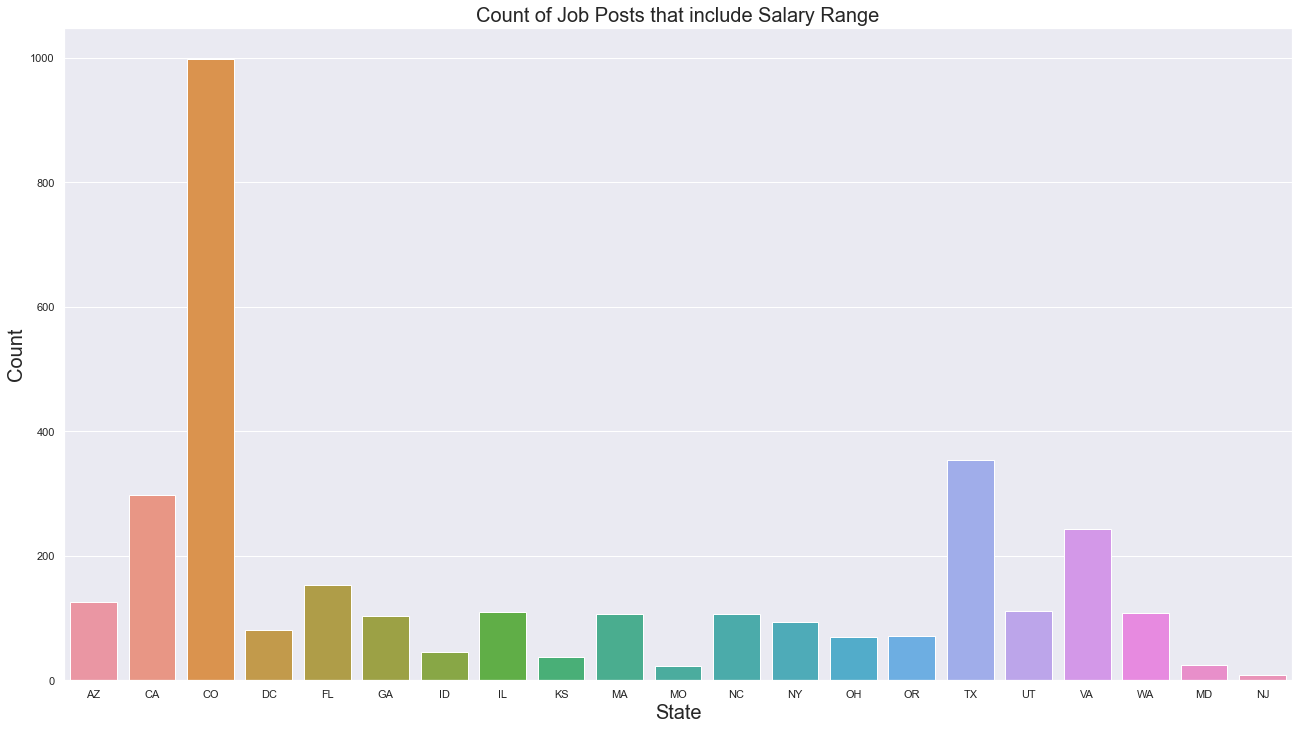

In [16]:
# Lets see what states share their salary the most
salary_by_job_state_count = (
    indeed_df[
        ((indeed_df["job_category"] != "Other") & (indeed_df["est_annual_salary"] > 0))
    ]
    .groupby(["job_category", "state"])["est_annual_salary"]
    .count()
    .reset_index()
)
sns.set(rc={"figure.figsize": (22, 12)})
ax = sns.barplot(
    x="state",
    y="est_annual_salary",
    data=salary_by_job_state_count,
    estimator=sum,
    ci=None,
)
plt.title("Count of Job Posts that include Salary Range", fontsize=20)
plt.xlabel("State", fontsize=20)
plt.ylabel("Count", fontsize=20)
plt.savefig("Images/Count_of_Job_Posts_that_include_Salary_Range.png")


In [17]:
salary_by_job_state_count = (
    indeed_df[
        ((indeed_df["job_category"] != "Other") & (indeed_df["est_annual_salary"] > 0))
    ]
    .groupby(["state"])["est_annual_salary"]
    .count()
    .reset_index()
)
job_count_by_state = (
    indeed_df[(indeed_df["job_category"] != "Other")]
    .groupby(["state"])["job_title"]
    .count()
    .reset_index()
)
jobs_joined = pd.merge(
    job_count_by_state, salary_by_job_state_count, how="left", on=["state"]
)
jobs_joined["percentage"] = jobs_joined["est_annual_salary"] / jobs_joined["job_title"]
jobs_joined


,state,job_title,est_annual_salary,percentage
0,AL,1,NaN,NaN
1,AZ,569,125.0,0.219684
2,CA,2037,298.0,0.146294
3,CO,1248,998.0,0.799679
4,DC,259,80.0,0.308880
5,FL,1251,153.0,0.122302
6,GA,712,103.0,0.144663
7,ID,314,45.0,0.143312
8,IL,764,110.0,0.143979
9,KS,179,37.0,0.206704


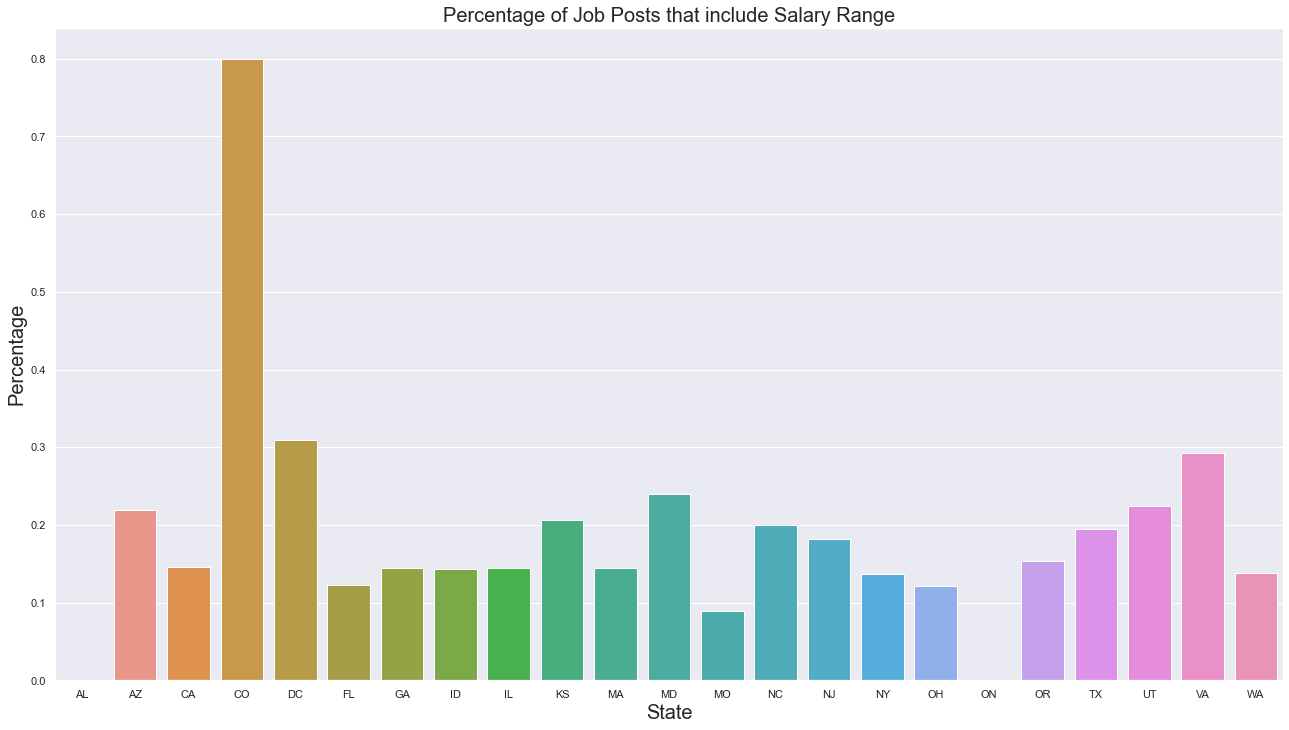

In [18]:
sns.set(rc={"figure.figsize": (22, 12)})
ax = sns.barplot(x="state", y="percentage", data=jobs_joined, ci=None)
plt.title("Percentage of Job Posts that include Salary Range", fontsize=20)
plt.xlabel("State", fontsize=20)
plt.ylabel("Percentage", fontsize=20)
plt.savefig("Images/Perc_of_Job_Posts_that_include_Salary_Range.png")


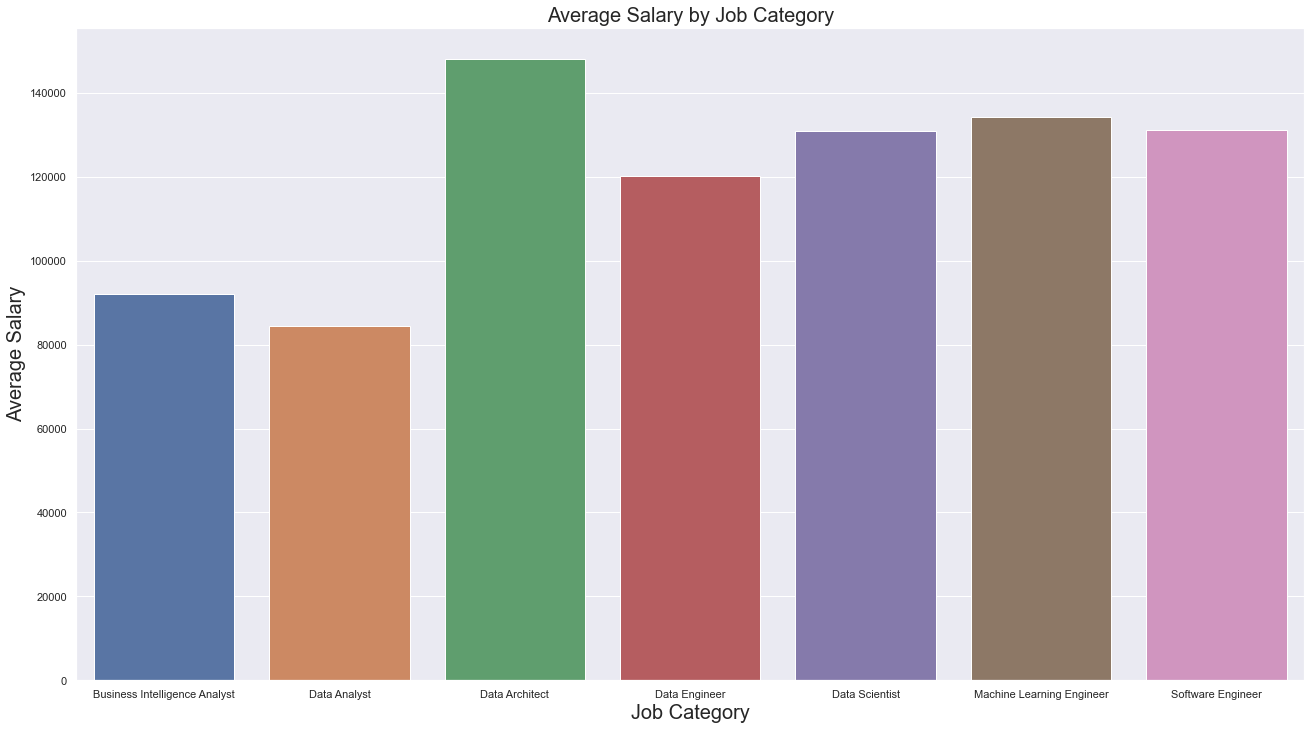

In [19]:
salary_by_job_state_mean = (
    indeed_df[
        ((indeed_df["job_category"] != "Other") & (indeed_df["est_annual_salary"] > 0))
    ]
    .groupby(["job_category"])["est_annual_salary"]
    .mean()
    .reset_index()
)
sns.set(rc={"figure.figsize": (22, 12)})
ax = sns.barplot(x="job_category", y="est_annual_salary", data=salary_by_job_state_mean)
plt.title("Average Salary by Job Category", fontsize=20)
plt.xlabel("Job Category", fontsize=20)
plt.ylabel("Average Salary", fontsize=20)
plt.savefig("Images/Average_Salary_by_Job_Category.png")


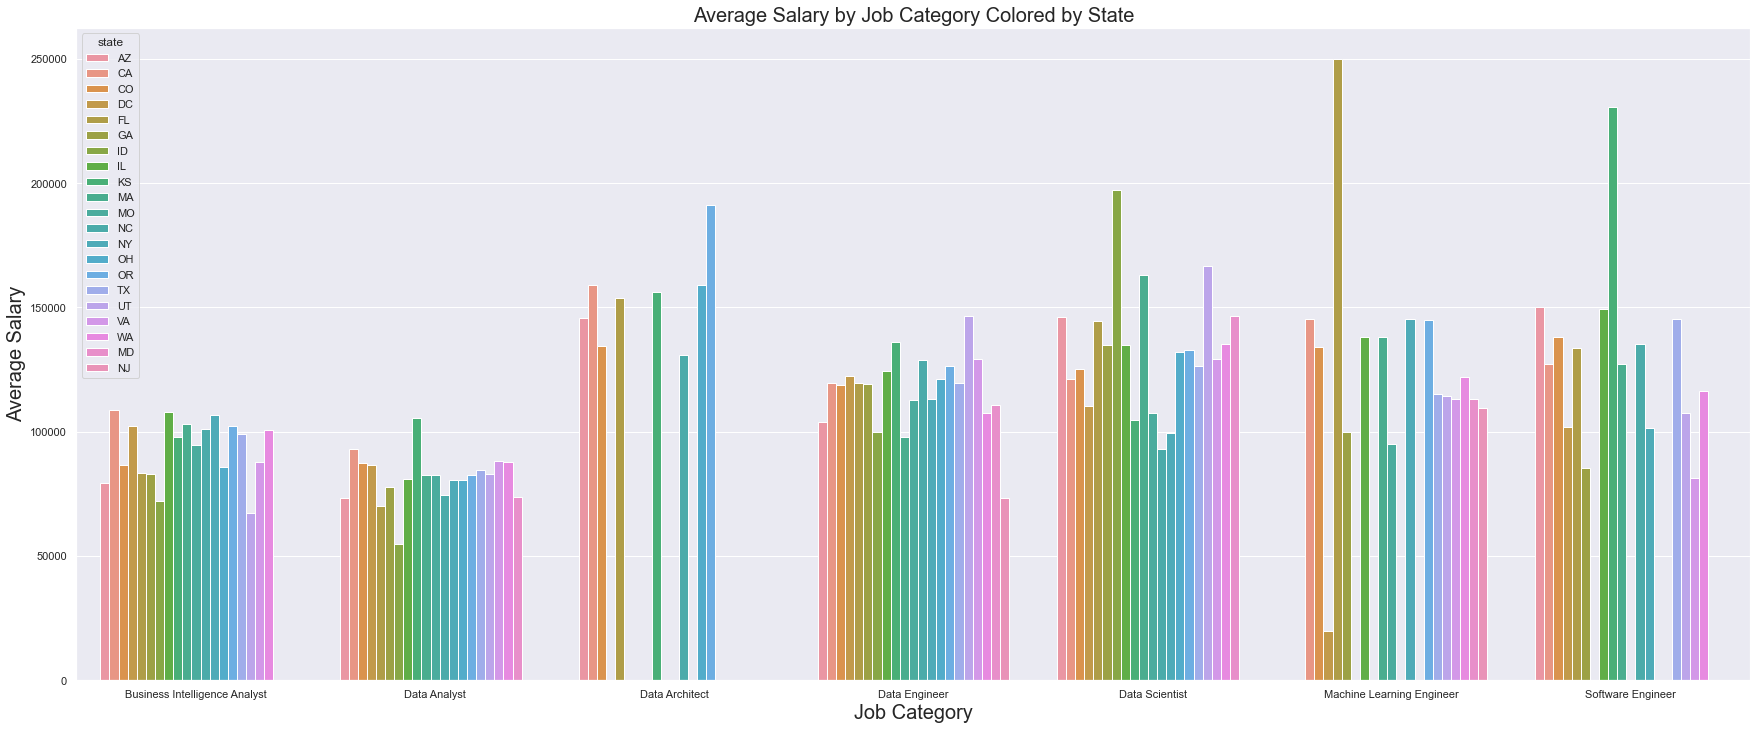

In [20]:
salary_by_job_state_mean = (
    indeed_df[
        ((indeed_df["job_category"] != "Other") & (indeed_df["est_annual_salary"] > 0))
    ]
    .groupby(["job_category", "state"])["est_annual_salary"]
    .mean()
    .reset_index()
)
sns.set(rc={"figure.figsize": (30, 12)})
ax = sns.barplot(
    x="job_category", y="est_annual_salary", hue="state", data=salary_by_job_state_mean
)
plt.title("Average Salary by Job Category Colored by State", fontsize=20)
plt.xlabel("Job Category", fontsize=20)
plt.ylabel("Average Salary", fontsize=20)
plt.savefig("Images/Average_Salary_by_Job_Category_by_State.png")


## Glassdoor

Look at benefits ratings generally

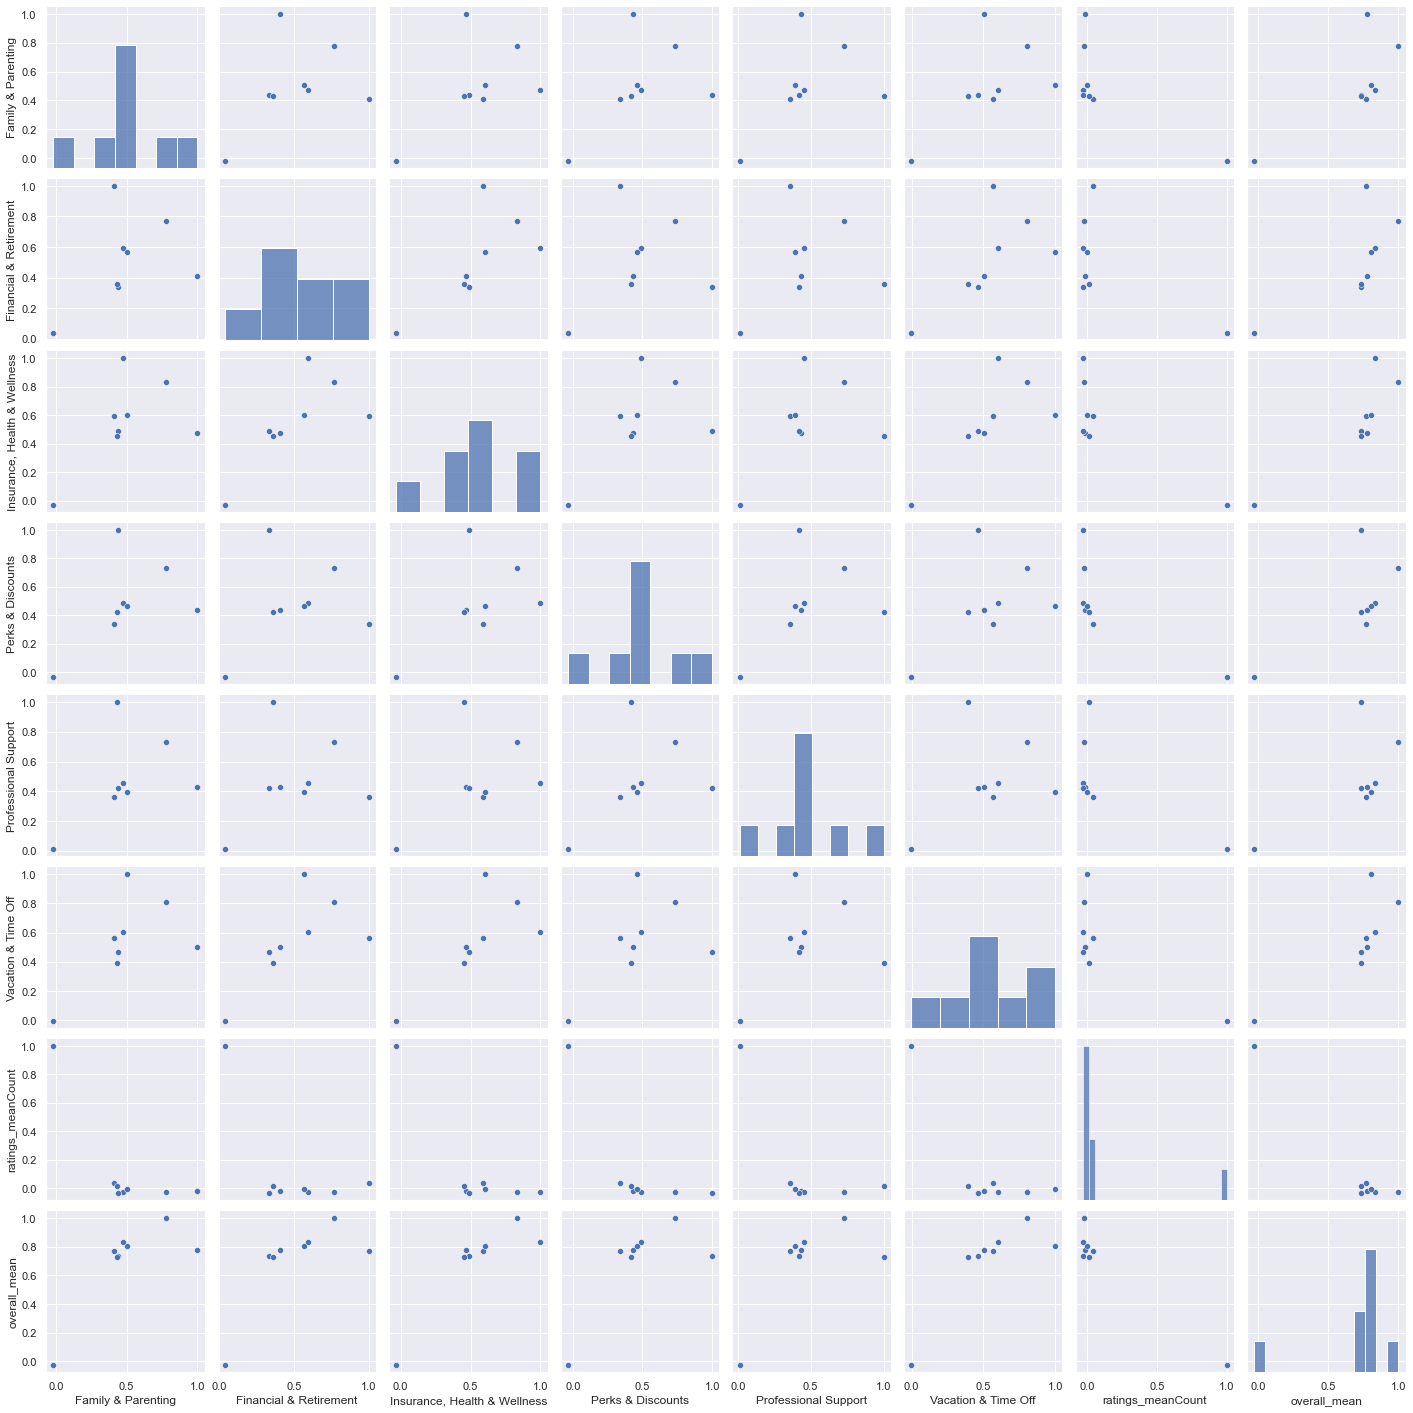

In [21]:
# Correlations on everything
sns.pairplot(scaleScore_df.corr())
plt.show()


In [22]:
glassdoor_df.head(10)


,companies,rating,count_of_ratings,new_type,sub_type
0,Visa,3.7,157,"Insurance, Health & Wellness",Health Insurance
1,Visa,3.6,21,"Insurance, Health & Wellness",Dental Insurance
2,Visa,3.6,18,"Insurance, Health & Wellness",Vision Insurance
3,Visa,3.4,13,"Insurance, Health & Wellness",Life Insurance
4,Visa,3.0,7,"Insurance, Health & Wellness",Health Savings Account (HSA)
5,Visa,2.8,6,"Insurance, Health & Wellness",Accidental Death & Dismemberment Insurance
6,Visa,2.8,6,"Insurance, Health & Wellness",Disability Insurance
7,Visa,3.2,5,"Insurance, Health & Wellness",Flexible Spending Account (FSA)
8,Visa,2.8,5,"Insurance, Health & Wellness",Mental Health Care
9,Visa,1.7,3,"Insurance, Health & Wellness",Supplemental Life Insurance


[]

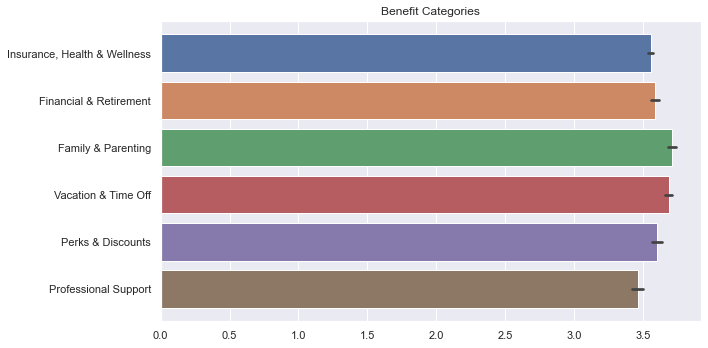

In [23]:
# Which benefit categories have the highest ratings?
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=glassdoor_df, y="new_type", x="rating").set(
    xlabel=None, ylabel=None, title="Benefit Categories"
)

plt.tight_layout()
plt.plot()


All categories have fairly high ratings. Lets look at subcategories by group.

[]

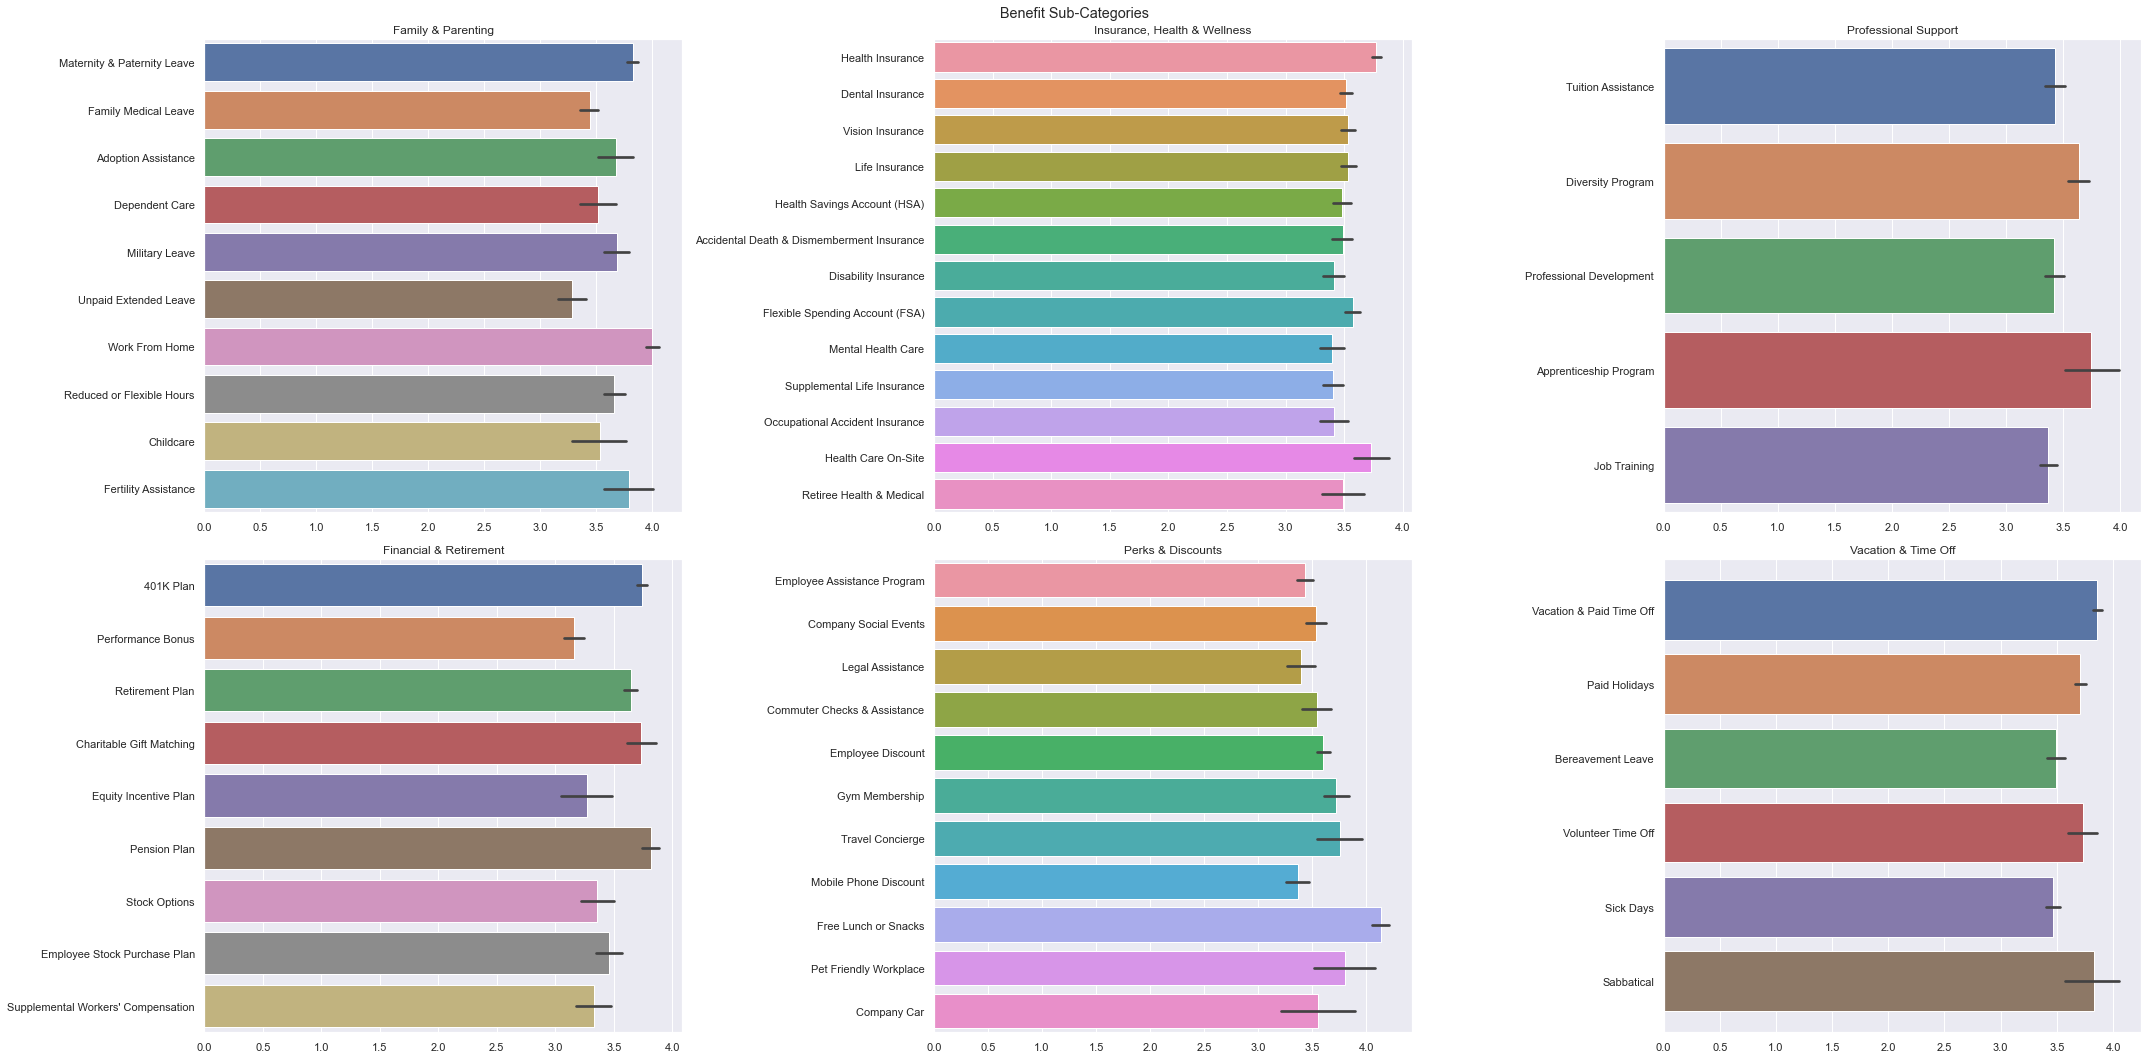

In [24]:
# Which benefit categories have the highest ratings?
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(30, 15))
sns.barplot(
    data=glassdoor_df[glassdoor_df["new_type"] == "Family & Parenting"],
    y="sub_type",
    x="rating",
    ax=ax[0, 0],
).set(title="Family & Parenting", xlabel=None, ylabel=None)
sns.barplot(
    data=glassdoor_df[glassdoor_df["new_type"] == "Financial & Retirement"],
    y="sub_type",
    x="rating",
    ax=ax[1, 0],
).set(title="Financial & Retirement", xlabel=None, ylabel=None)
sns.barplot(
    data=glassdoor_df[glassdoor_df["new_type"] == "Insurance, Health & Wellness"],
    y="sub_type",
    x="rating",
    ax=ax[0, 1],
).set(title="Insurance, Health & Wellness", xlabel=None, ylabel=None)
sns.barplot(
    data=glassdoor_df[glassdoor_df["new_type"] == "Perks & Discounts"],
    y="sub_type",
    x="rating",
    ax=ax[1, 1],
).set(title="Perks & Discounts", xlabel=None, ylabel=None)
sns.barplot(
    data=glassdoor_df[glassdoor_df["new_type"] == "Professional Support"],
    y="sub_type",
    x="rating",
    ax=ax[0, 2],
).set(title="Professional Support", xlabel=None, ylabel=None)
sns.barplot(
    data=glassdoor_df[glassdoor_df["new_type"] == "Vacation & Time Off"],
    y="sub_type",
    x="rating",
    ax=ax[1, 2],
).set(title="Vacation & Time Off", xlabel=None, ylabel=None)
fig.suptitle("Benefit Sub-Categories")

plt.tight_layout()
plt.plot()


In [25]:
# Let's only look at the companies with the highest ratings (only including companies that have at least 10 ratings per category on average)
mostRated = scaleScore_df[scaleScore_df["ratings_meanCount"] >= 10].nlargest(
    10, "overall_mean"
)

mostRated


,companies,Family & Parenting,Financial & Retirement,"Insurance, Health & Wellness",Perks & Discounts,Professional Support,Vacation & Time Off,ratings_meanCount,overall_mean
1978,The Hanover Insurance Group,5.000000,4.600000,4.300000,4.000000,NaN,4.800000,11.000000,4.540000
1723,Salesforce,4.733835,4.431048,4.582927,4.501852,4.100000,4.626250,27.666667,4.495985
900,Google,4.619463,4.601604,4.612454,4.659918,3.838462,4.388095,32.229167,4.453333
2069,UKG (Ultimate Kronos Group),4.632558,4.358273,4.484848,4.631250,4.063636,4.493694,16.157895,4.444043
1826,Southwest Airlines,4.273529,4.695477,4.358929,4.413115,4.547826,4.262376,15.837838,4.425209
1827,Southwest Airlines Co.,4.273529,4.695477,4.358929,4.413115,4.547826,4.262376,15.837838,4.425209
1392,New Relic,4.490909,3.880000,4.500000,5.000000,NaN,4.100000,11.000000,4.394182
189,AstraZeneca,4.206122,4.463235,4.035714,4.442857,4.800000,4.390909,10.260870,4.389806
160,Apple,4.555696,4.416726,4.486594,4.209366,4.284932,4.273571,62.913043,4.371147
1213,MIT,3.846429,4.390566,4.390977,4.087500,4.618182,4.350000,11.592593,4.280609


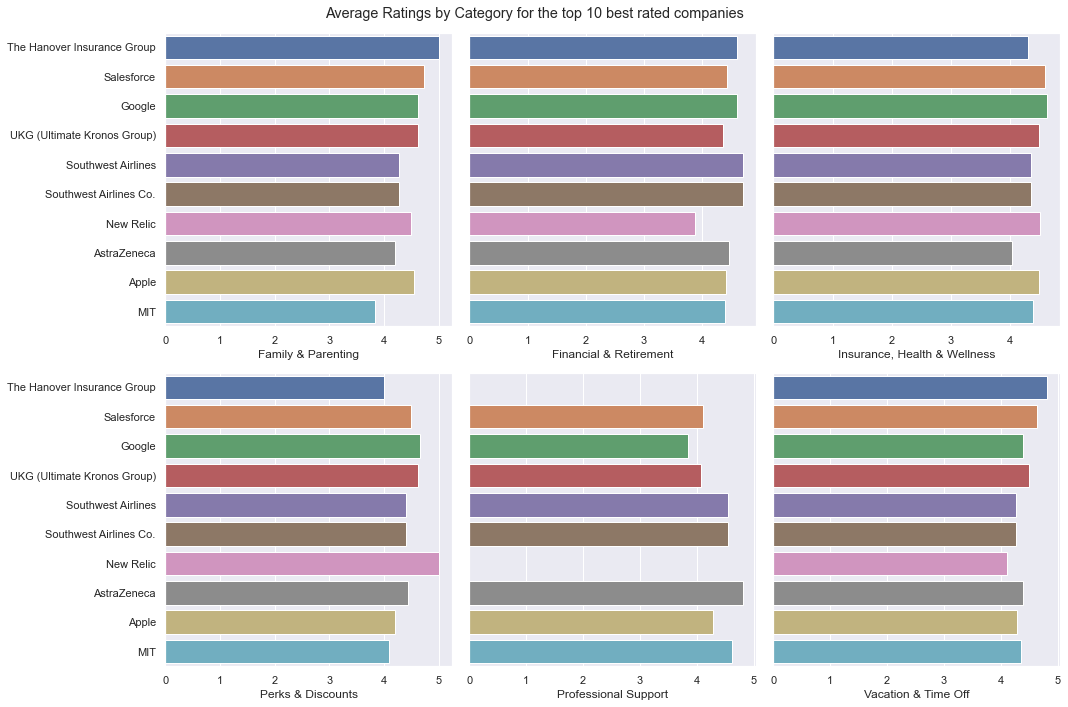

In [26]:
# Best Ratings by Category for the top 10 best rated companies
fig, ax = plt.subplots(ncols=3, nrows=2, sharey=True, figsize=(15, 10))
sns.barplot(data=mostRated, x="Family & Parenting", y="companies", ax=ax[0, 0]).set(
    ylabel=None
)
sns.barplot(data=mostRated, x="Financial & Retirement", y="companies", ax=ax[0, 1]).set(
    ylabel=None
)
sns.barplot(
    data=mostRated, x="Insurance, Health & Wellness", y="companies", ax=ax[0, 2]
).set(ylabel=None)
sns.barplot(data=mostRated, x="Perks & Discounts", y="companies", ax=ax[1, 0]).set(
    ylabel=None
)
sns.barplot(data=mostRated, x="Professional Support", y="companies", ax=ax[1, 1]).set(
    ylabel=None
)
sns.barplot(data=mostRated, x="Vacation & Time Off", y="companies", ax=ax[1, 2]).set(
    ylabel=None
)
fig.suptitle("Average Ratings by Category for the top 10 best rated companies")

plt.tight_layout()
plt.show()


Different companies have different strengths regarding their ratings on each category. 

## Look at benefits ratings for companies 

In [27]:
# By companies with the most job postings

compCounts = indeed_df["company_name"].value_counts().to_frame()
compCounts.columns = ["count_of_jobs"]

# Create groups for the job counts
compCounts["bins"] = pd.cut(compCounts["count_of_jobs"], bins=10)

compCounts


,count_of_jobs,bins
Deloitte,483,"(434.8, 483.0]"
Amazon.com Services LLC,359,"(338.4, 386.6]"
PRICE WATERHOUSE COOPERS,316,"(290.2, 338.4]"
"JPMorgan Chase Bank, N.A.",309,"(290.2, 338.4]"
Accenture,298,"(290.2, 338.4]"
...,...,...
BCD Travel Corporate,1,"(0.518, 49.2]"
Zimmer Biomet,1,"(0.518, 49.2]"
UF Jacksonville,1,"(0.518, 49.2]"
Axos Clearing LLC,1,"(0.518, 49.2]"


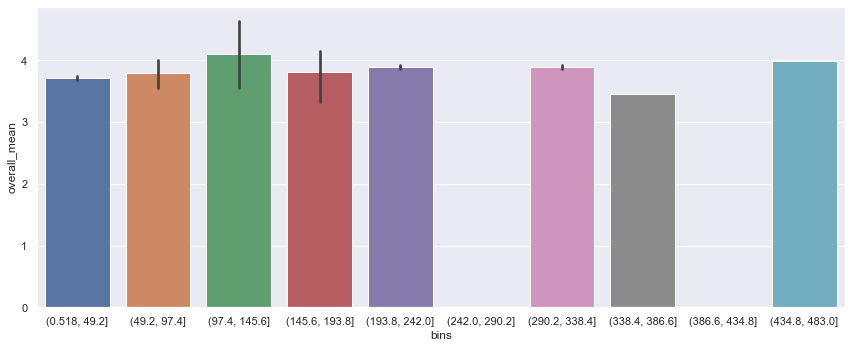

In [28]:
# See if companies with more job openings have better or worse overall ratings

openings_df = scaleScore_df.merge(
    compCounts, how="left", left_on="companies", right_on=compCounts.index
)

fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(x="bins", y="overall_mean", data=openings_df)

plt.tight_layout()
plt.show()


For the most part ratings are fairly high. Companies with fewer job openings appear to have more variability in their ratings

In [29]:
indeed_df.sample(4)


,index,job_title,company_name,company_location,est salary,job_href,job_desc,est_salary,retrieve_date,salary_extract,job_category,state,salary_low,salary_high,pay_rate,est_annual_salary
1511,11,Senior Data Engineer - Opportunity for Working...,VMware,"Remote in Miami, FL",None,https://www.indeed.com/rc/clk?jk=26c43a68a189f...,Business Summary: VMware is the leader in virt...,No Estimated Salary,2022-02-07,None,Data Engineer,FL,NaN,NaN,None,NaN
3382,4,Data Analyst,Dignari,"Remote in Washington, DC",None,https://www.indeed.com/company/Dignari/jobs/Da...,"Dignari is a forward-thinking, human-centered,...",No Estimated Salary,2022-02-12,None,Data Analyst,DC,NaN,NaN,None,NaN
780,2,Data Scientist II – Bank (100% Remote Work Ava...,USAA,"Remote in San Antonio, TX",None,https://www.indeed.com/rc/clk?jk=56f432f34a924...,Purpose of Job We are seeking a talented Data ...,No Estimated Salary,2022-02-07,"72,900 - 131,400 a year",Data Scientist,TX,72900.0,131400.0,annual,102150.0
3028,6,Data Engineer,Cognizant Technology Solutions,"Raleigh, NC",None,https://www.indeed.com/rc/clk?jk=e7febbf0f54de...,Technical Lead Qualification: Bachelors in sci...,No Estimated Salary,2022-02-12,None,Data Engineer,NC,NaN,NaN,None,NaN


In [30]:
scaleScore_df.sample(4)


,companies,Family & Parenting,Financial & Retirement,"Insurance, Health & Wellness",Perks & Discounts,Professional Support,Vacation & Time Off,ratings_meanCount,overall_mean
1053,Intermountain Healthcare,3.05,3.902299,3.630729,3.389130,3.558333,3.455882,12.714286,3.497729
1873,Strategic Financial Solutions,1.50,2.490000,1.585714,1.909091,1.400000,2.410000,3.789474,1.882468
1893,Swift Prepared Foods,NaN,NaN,3.000000,NaN,NaN,NaN,1.000000,3.000000
2286,Wycliffe Bible Translators,4.00,NaN,2.000000,NaN,NaN,NaN,1.500000,3.000000


## Combining Indeed with Glassdoor

In [31]:
# Let's merge the glassdoor and linked in dataframes
combined_df = indeed_df.merge(
    scaleScore_df, left_on="company_name", right_on="companies", how="left"
)


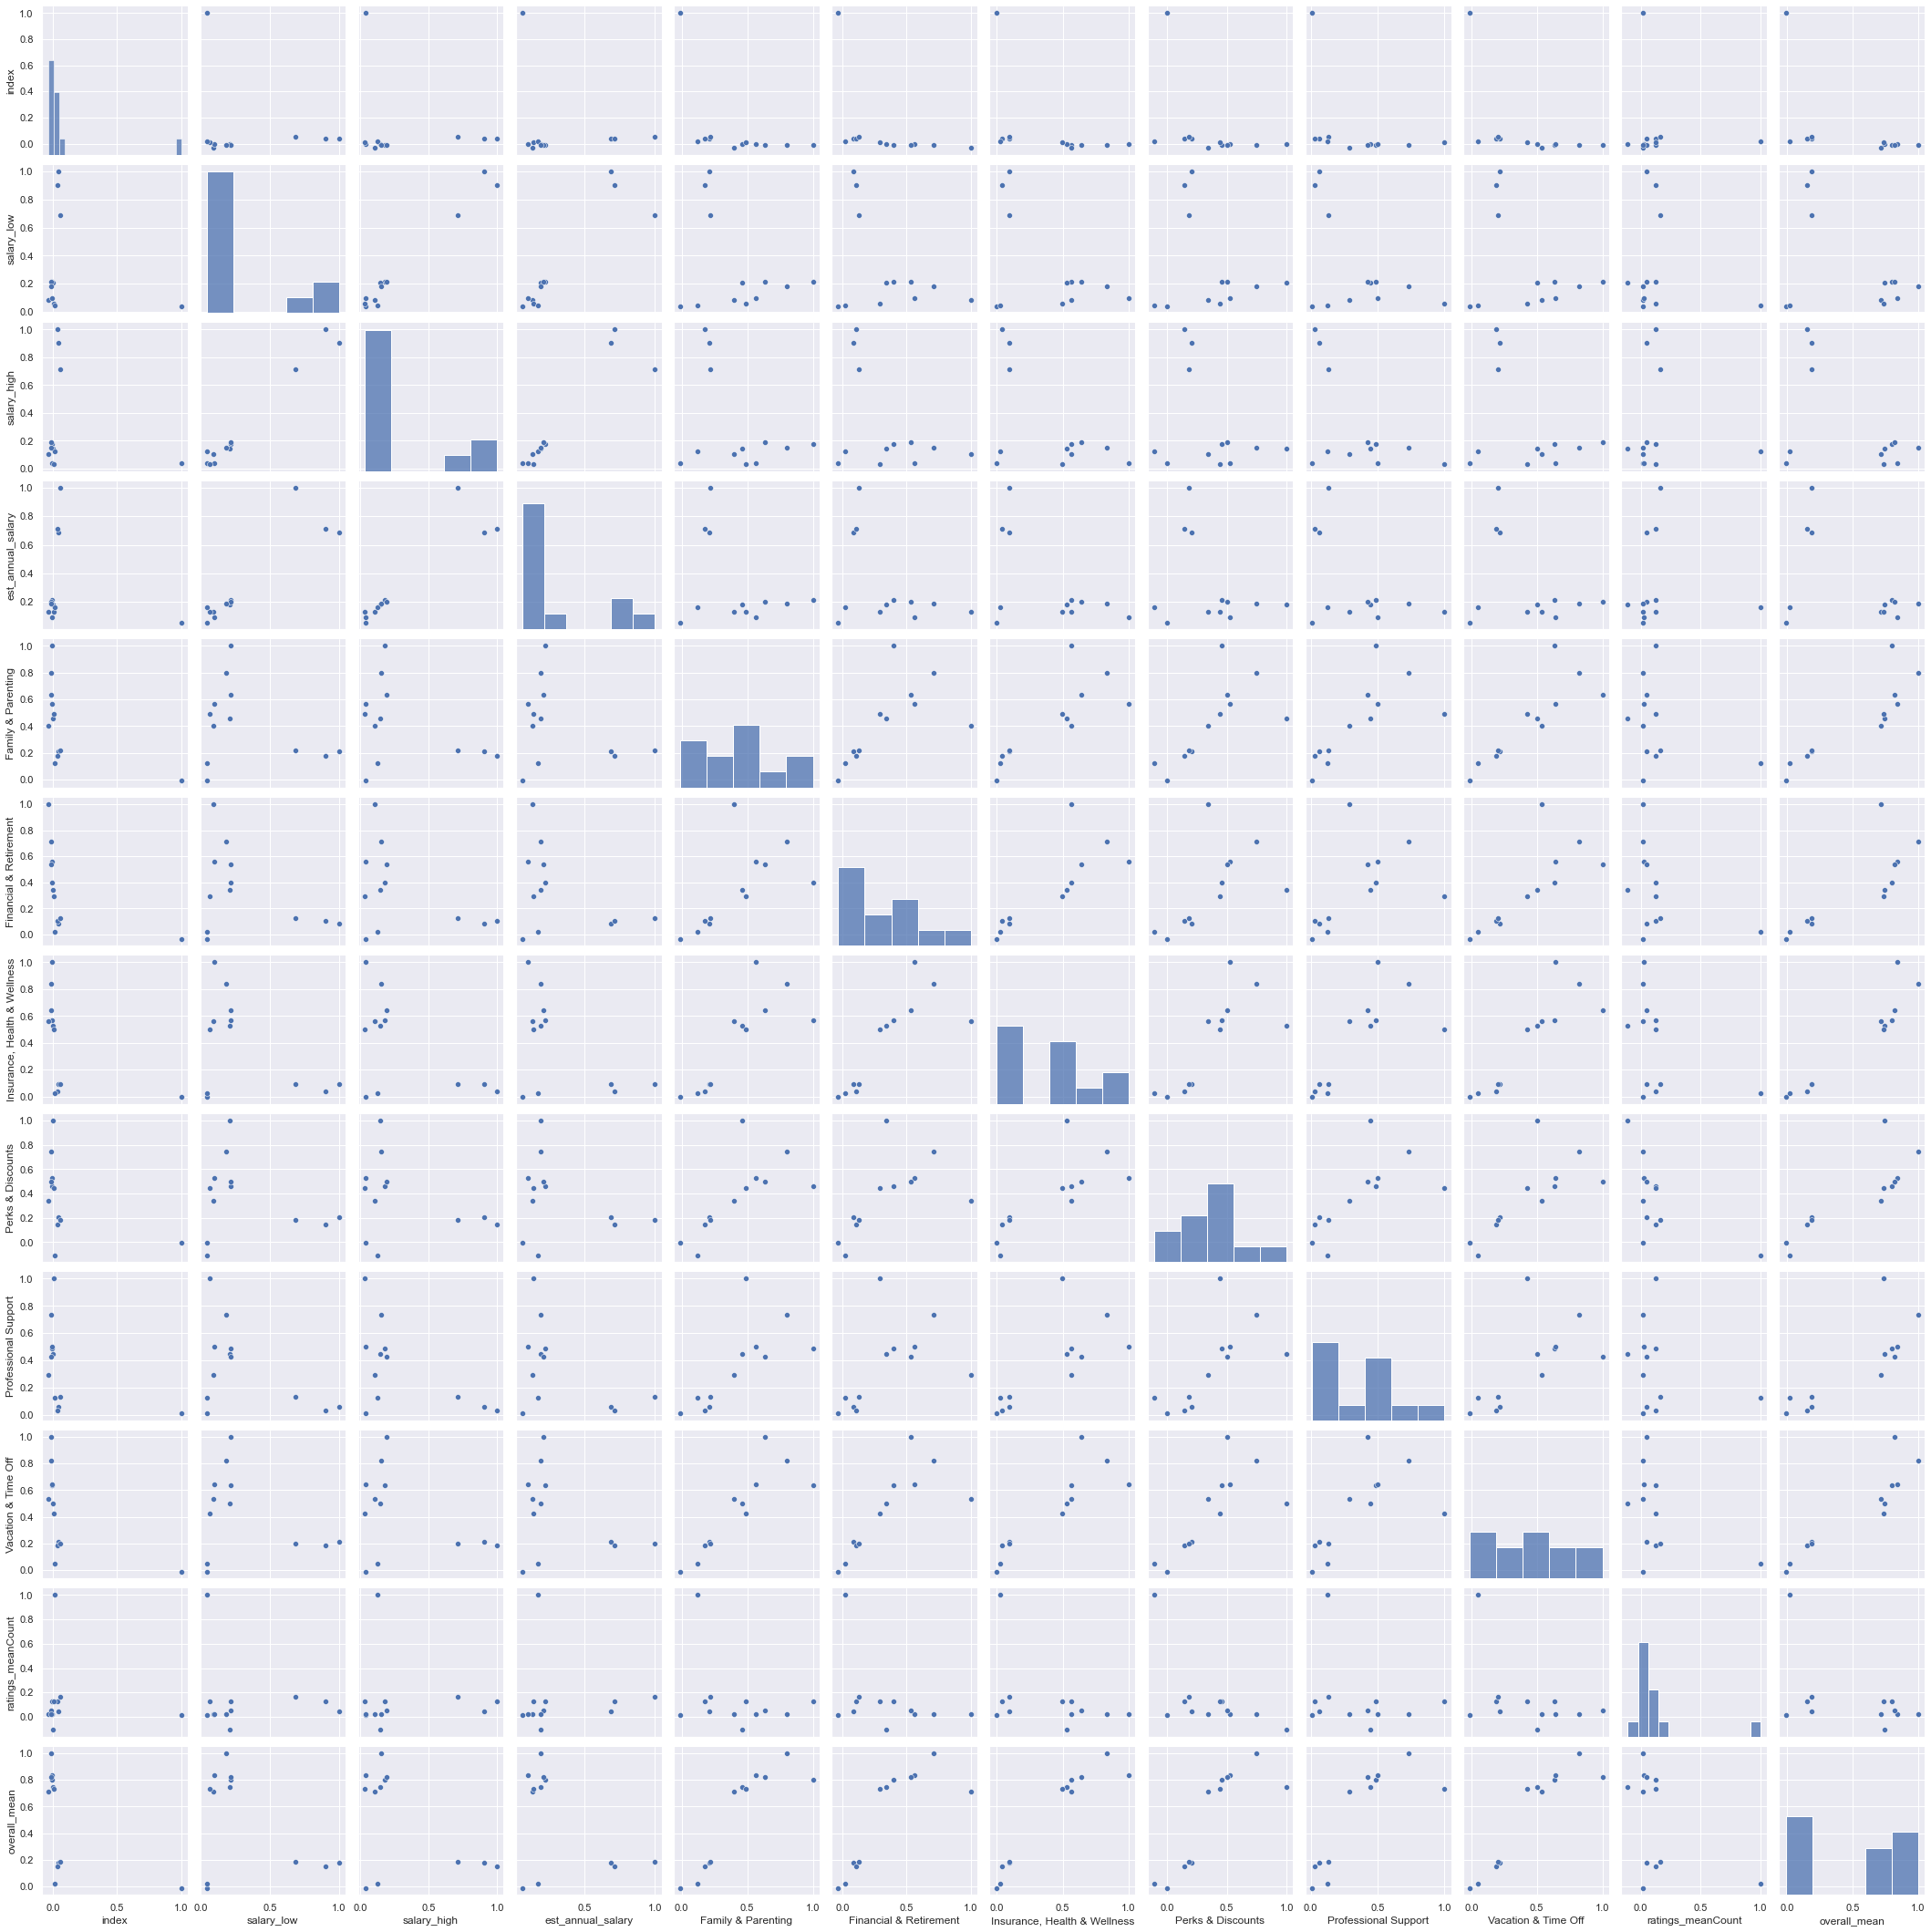

In [32]:
# check correlations with the combined datasets

sns.pairplot(combined_df.corr())
plt.show()


Nothing really stands out from these correlations

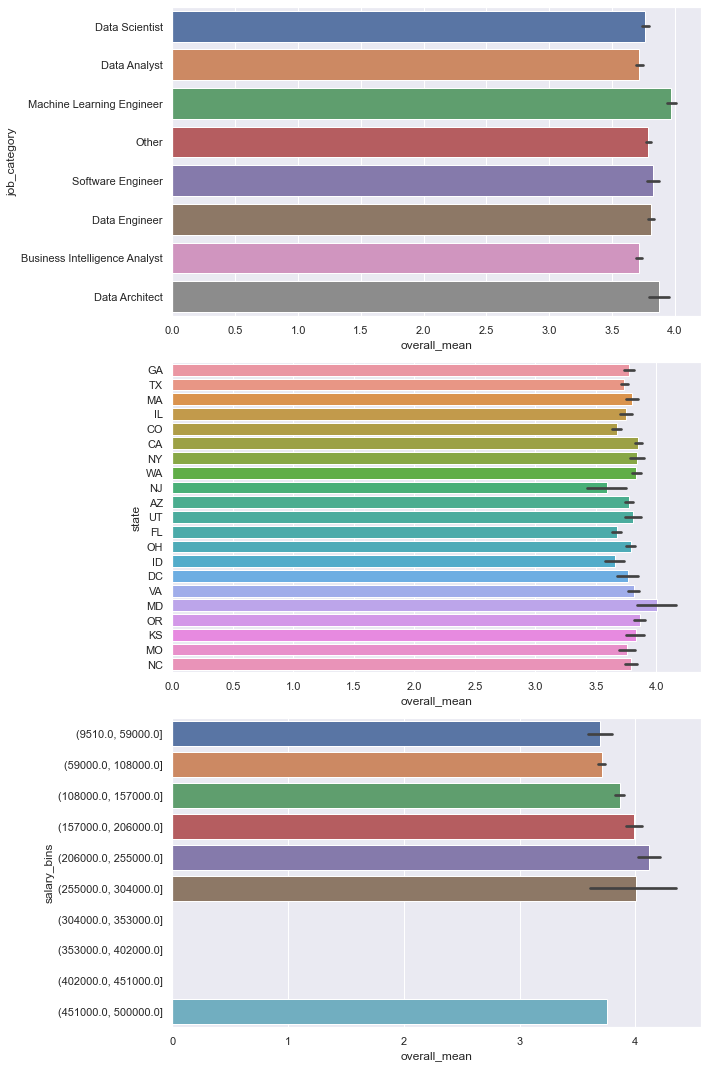

In [33]:
# Look at ratings by job category, state, and estimated annual salary

# Create groups for salary
combined_df["salary_bins"] = pd.cut(combined_df["est_annual_salary"], bins=10)

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))
sns.barplot(x="overall_mean", y="job_category", data=combined_df, ax=ax[0])
sns.barplot(
    x="overall_mean",
    y="state",
    data=combined_df[
        combined_df["state"].map(combined_df["state"].value_counts()) > 10
    ],
    ax=ax[1],
)
sns.barplot(x="overall_mean", y="salary_bins", data=combined_df, ax=ax[2])

plt.tight_layout()
plt.show()


Closer look at the three figures above by the 6 domains

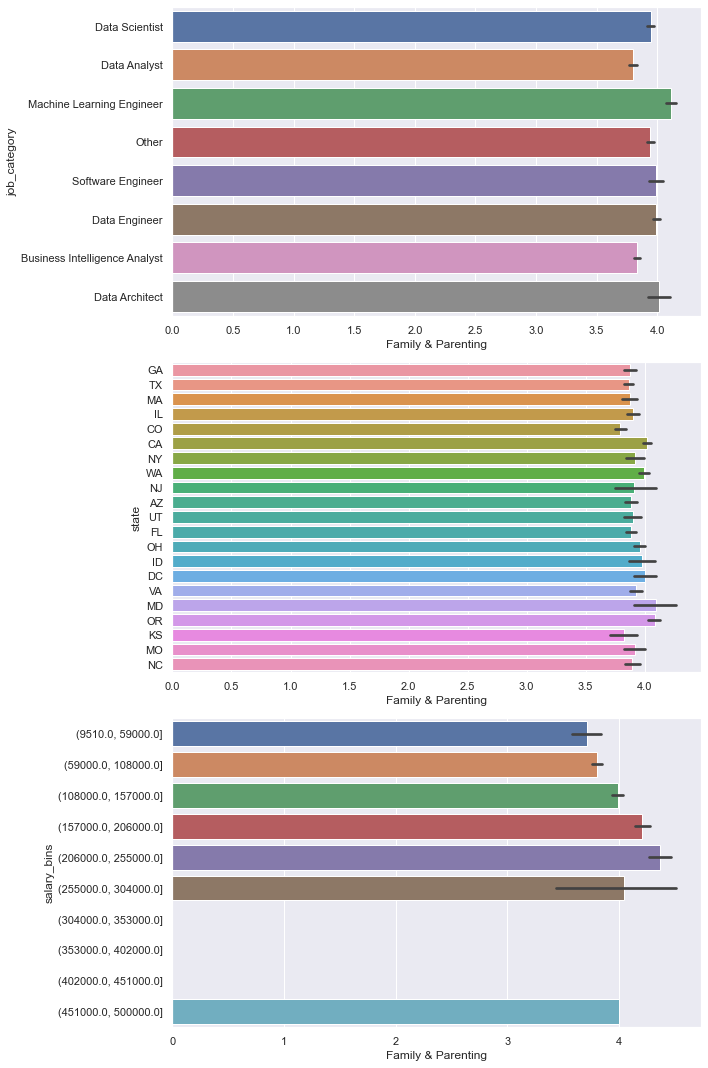

In [34]:
# "Family & Parenting",
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))
sns.barplot(x="Family & Parenting", y="job_category", data=combined_df, ax=ax[0])
sns.barplot(
    x="Family & Parenting",
    y="state",
    data=combined_df[
        combined_df["state"].map(combined_df["state"].value_counts()) > 10
    ],
    ax=ax[1],
)
sns.barplot(x="Family & Parenting", y="salary_bins", data=combined_df, ax=ax[2])

plt.tight_layout()
plt.show()


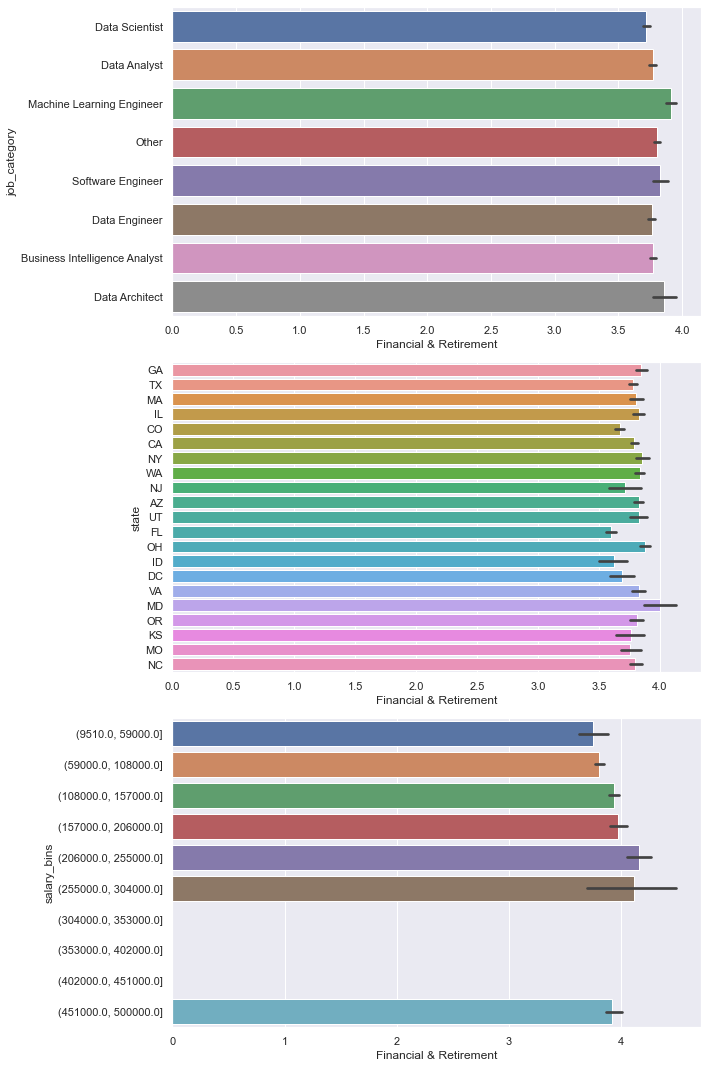

In [35]:
#         "Financial & Retirement",
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))
sns.barplot(x="Financial & Retirement", y="job_category", data=combined_df, ax=ax[0])
sns.barplot(
    x="Financial & Retirement",
    y="state",
    data=combined_df[
        combined_df["state"].map(combined_df["state"].value_counts()) > 10
    ],
    ax=ax[1],
)
sns.barplot(x="Financial & Retirement", y="salary_bins", data=combined_df, ax=ax[2])

plt.tight_layout()
plt.show()


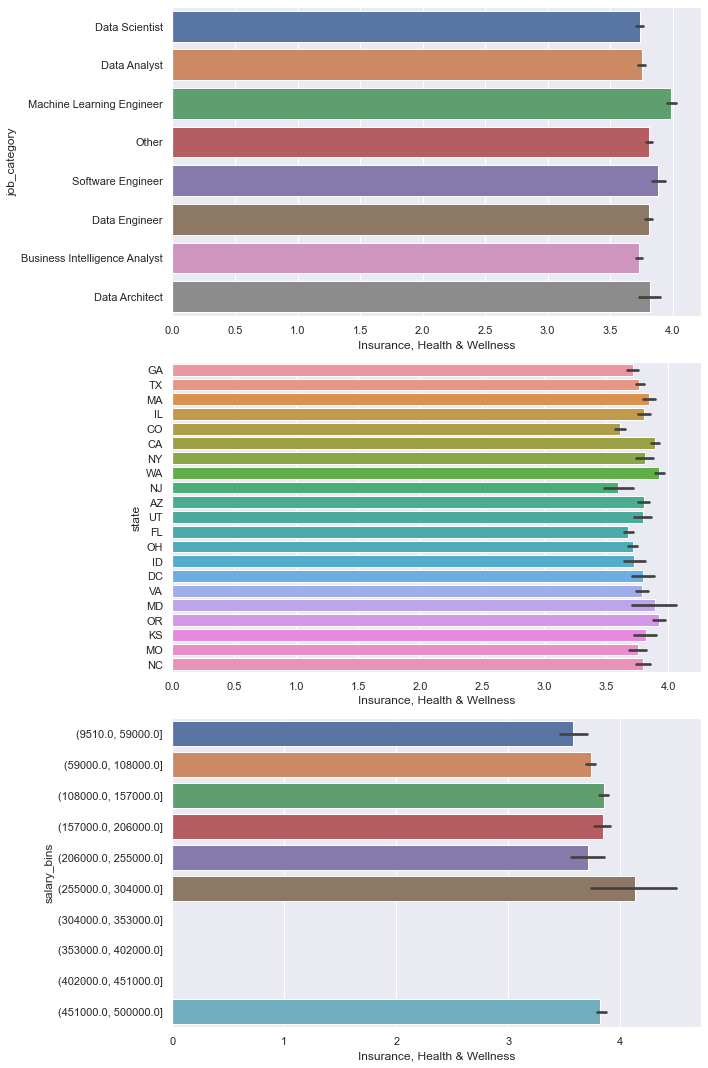

In [36]:
#         "Insurance, Health & Wellness",
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))
sns.barplot(
    x="Insurance, Health & Wellness", y="job_category", data=combined_df, ax=ax[0]
)
sns.barplot(
    x="Insurance, Health & Wellness",
    y="state",
    data=combined_df[
        combined_df["state"].map(combined_df["state"].value_counts()) > 10
    ],
    ax=ax[1],
)
sns.barplot(
    x="Insurance, Health & Wellness", y="salary_bins", data=combined_df, ax=ax[2]
)

plt.tight_layout()
plt.show()


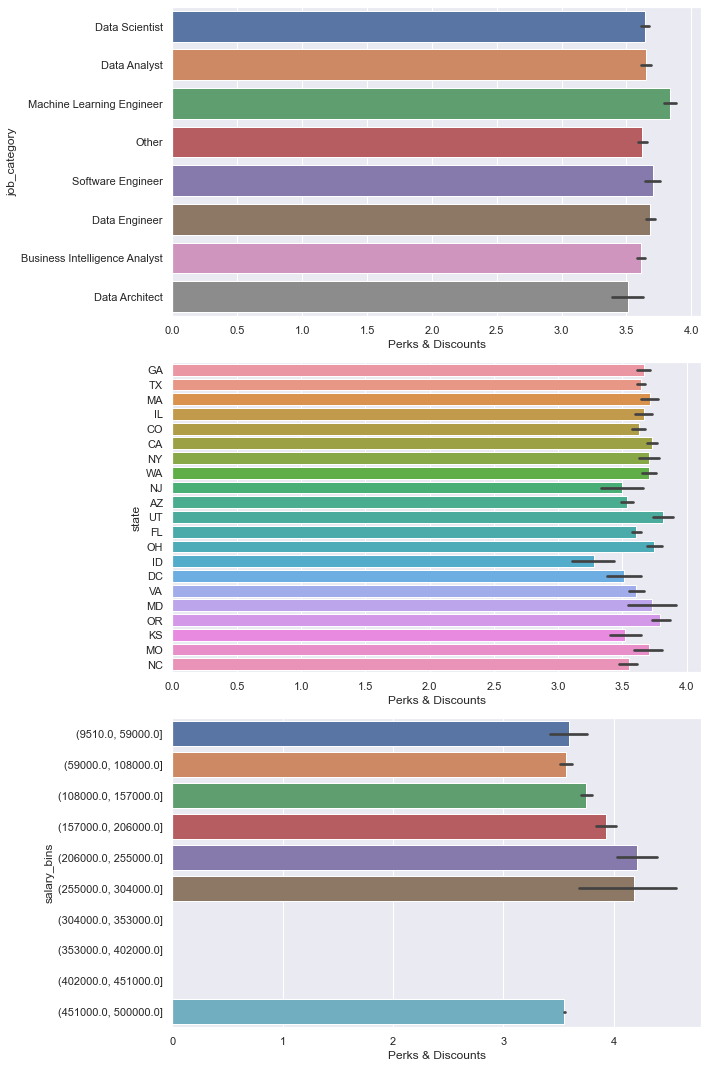

In [37]:
#         "Perks & Discounts",
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))
sns.barplot(x="Perks & Discounts", y="job_category", data=combined_df, ax=ax[0])
sns.barplot(
    x="Perks & Discounts",
    y="state",
    data=combined_df[
        combined_df["state"].map(combined_df["state"].value_counts()) > 10
    ],
    ax=ax[1],
)
sns.barplot(x="Perks & Discounts", y="salary_bins", data=combined_df, ax=ax[2])

plt.tight_layout()
plt.show()


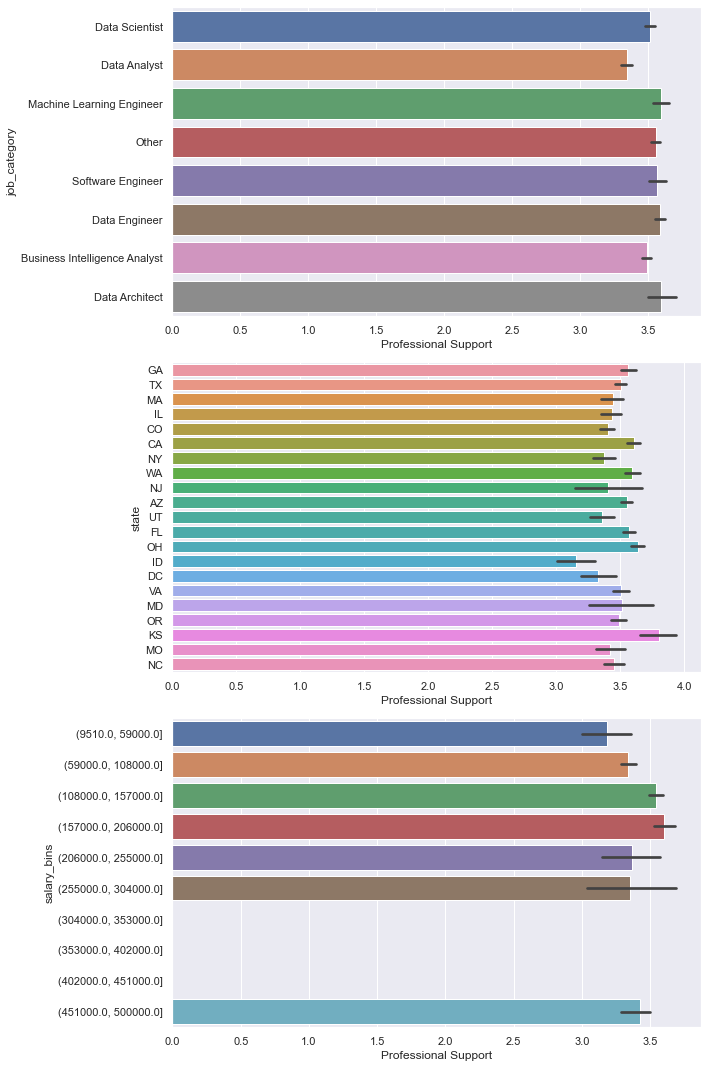

In [38]:
#         "Professional Support",
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))
sns.barplot(x="Professional Support", y="job_category", data=combined_df, ax=ax[0])
sns.barplot(
    x="Professional Support",
    y="state",
    data=combined_df[
        combined_df["state"].map(combined_df["state"].value_counts()) > 10
    ],
    ax=ax[1],
)
sns.barplot(x="Professional Support", y="salary_bins", data=combined_df, ax=ax[2])

plt.tight_layout()
plt.show()


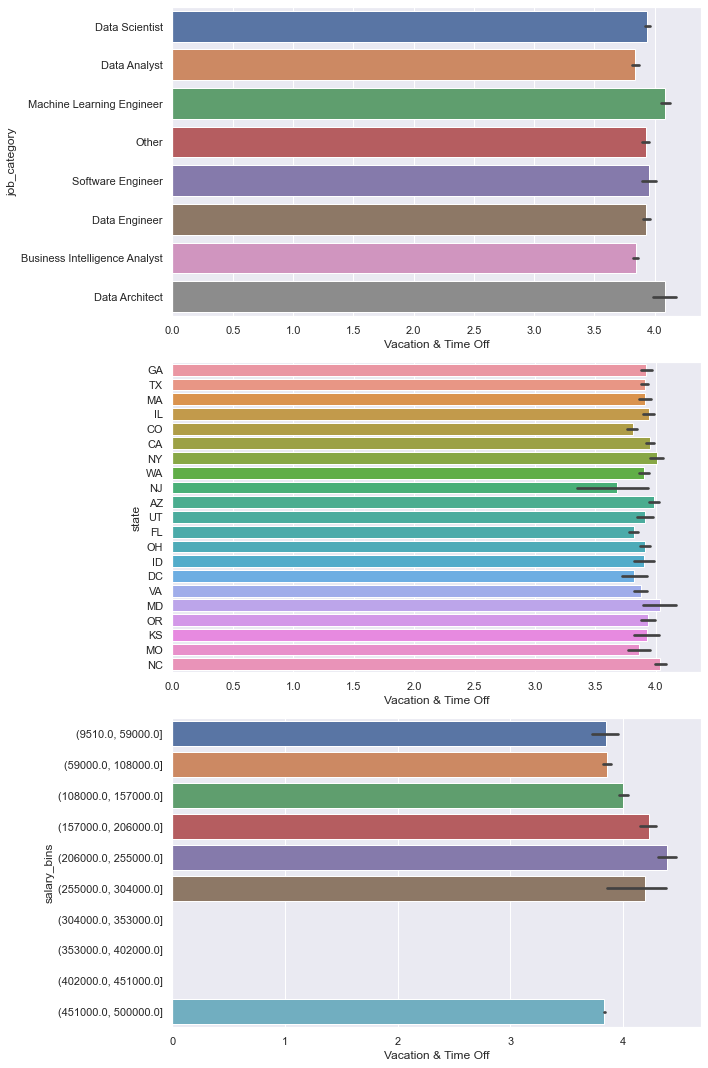

In [39]:
#         "Vacation & Time Off",
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))
sns.barplot(x="Vacation & Time Off", y="job_category", data=combined_df, ax=ax[0])
sns.barplot(
    x="Vacation & Time Off",
    y="state",
    data=combined_df[
        combined_df["state"].map(combined_df["state"].value_counts()) > 10
    ],
    ax=ax[1],
)
sns.barplot(x="Vacation & Time Off", y="salary_bins", data=combined_df, ax=ax[2])

plt.tight_layout()
plt.show()


# Natural Language Processing (NLP)

In [40]:
# Taking a sample of the indeed_df of the initial job cetegories that we were interested in
sample_df = indeed_df[
    indeed_df.job_category.isin(
        [
            "Data Scientist",
            "Data Analyst",
            "Machine Learning Engineer",
            "Data Engineer",
            "Business Intelligence Analyst",
            "Data Architect",
        ]
    )
].copy()


In [42]:
# Drop any rows where job description is blank
indeed_df.dropna(subset=["job_desc"], inplace=True)

# Taking a sample of the indeed_df of the initial job cetegories that we were interested in
sample_df = indeed_df[
    indeed_df.job_category.isin(
        [
            "Data Scientist",
            "Data Analyst",
            "Machine Learning Engineer",
            "Data Engineer",
            "Business Intelligence Analyst",
            "Data Architect",
        ]
    )
].copy()

# Expand our stoplist
stoplist = (
    [
        "year",
        "experience",
        "opportunity",
        "employer",
        "sexual",
        "orientation",
        "national",
        "origin" "veteran",
        "status",
        "work",
        "race",
        "color",
        "religion",
        "orientation",
        "gender",
        "regard",
        "this",
        "position" "related",
        "field",
        "closely",
        "with",
        "disability",
        "federal",
        "state",
        "local",
        "more",
        "than",
        "receive",
        "equal",
        "opportunity",
        "veteran",
        "protect",
        "employment",
        "consideration",
        "accommodation",
        "role",
        "employee",
        "benefit",
        "applicant",
        "such",
        "what",
        "their",
        "company",
        "understand",
        "their",
        "what",
        "minimum",
        "please",
        "which",
        "and/or",
        "vaccine",
        "vaccination",
        "understand",
        "their",
        "about",
        "what",
        "write",
        "within",
        "and/or",
        "qualify",
        "prefer",
        "policy",
        "vaccination",
        "vaccine",
        "time",
        "qualification",
        "qualify",
        "be",
        "without",
        "want",
        "prefer",
        "through",
        "like",
        "within",
        "inclusive",
        "inclusion",
        "organization",
        "leave",
        "base",
        "package",
        "bring",
        "must",
        "candidate",
        "without",
        "diversity",
    ]
    + [
        word.lower()
        for company in indeed_df.company_name.unique()
        for word in company.split(" ")
    ]
    # + [
    #     word.lower()
    #     for category in indeed_df.job_category.unique()
    #     for word in category.split(" ")
    # ]
    # + [
    #     word.lower()
    #     for title in indeed_df.job_title.unique()
    #     for word in title.split(" ")
    # ]
)


In [43]:
def preprocess(text):
    """1. Removes Punctuations
    2. Removes words smaller than 3 letters
    3. Converts into lowercase
    4. Lemmatizes words
    5. Removes Stopwords
    """
    punctuation = list(string.punctuation)
    doc_tokens = nltk.word_tokenize(text)
    word_tokens = [
        word.lower()
        for word in doc_tokens
        if not (word in punctuation or len(word) <= 3)
    ]
    doc_words = [word for word in doc_tokens if word not in stoplist]
    doc_words = [wordnet_lemmatizer.lemmatize(word) for word in doc_words]
    stemmer = nltk.stem.PorterStemmer()
    doc_words = [stemmer.stem(word) for word in doc_words]

    return doc_words


job_desc_df_clean = sample_df["job_desc"].apply(preprocess)

# Lemmatize
# pos_tags=nltk.pos_tag(word_tokens)
#     print(pos_tags)
# doc_words=[wordnet_lemmatizer.lemmatize(word, pos=get_pos_tag(tag)) for word, tag in pos_tags]


In [44]:
sample_df[sample_df.job_category != "Data Architect"].index


Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            17176, 17177, 17178, 17179, 17180, 17181, 17182, 17183, 17184,
            17185],
           dtype='int64', length=14061)

In [45]:
target_job_descs = job_desc_df_clean[
    sample_df[sample_df.job_category != "Data Architect"].index
]


## Implementing TF-IDF

In [46]:
vectorizer = TfidfVectorizer(
    lowercase=True,
    max_features=100,
    max_df=0.8,
    min_df=5,
    ngram_range=(1, 3),
    stop_words="english",
)

cleaned_docs = [" ".join(doc) for doc in job_desc_df_clean]
vectors = vectorizer.fit_transform(cleaned_docs)


In [47]:
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()


In [48]:
all_keywords = []
for description in denselist:
    x = 0
    keywords = []
    for word in description:
        if word > 0:
            keywords.append(feature_names[x])
        x = x + 1
    all_keywords.append(keywords)


## Implementing K-means

In [49]:
true_k = 6
model = KMeans(n_clusters=true_k, init="k-means++", max_iter=100, n_init=1)


In [50]:
model.fit(vectors)

order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()


In [51]:
i = 0
for cluster in order_centroids:
    print(f"Cluster {i}")
    print([terms[keyword] for keyword in cluster[0:20]])
    # for keyword in cluster[0:15]:
    #     print (terms[keyword])
    # print ("")
    i = i + 1


Cluster 0
['applic', 'employe', 'client', 'law', 'includ', 'ani', 'process', 'provid', 'need', 'employ', 'data', 'commit', 'posit', 'protect', 'help', 'use', 'respons', 'year', 'offer', 'develop']
Cluster 1
['machin', 'model', 'learn', 'engin', 'experi', 'data', 'statist', 'develop', 'product', 'applic', 'use', 'scienc', 'includ', 'problem', 'custom', 'build', 'python', 'year', 'process', 'help']
Cluster 2
['process', 'document', 'busi', 'applic', 'user', 'test', 'manag', 'function', 'provid', 'analyst', 'includ', 'develop', 'project', 'ensur', 'need', 'posit', 'custom', 'meet', 'commun', 'product']
Cluster 3
['insight', 'custom', 'product', 'data', 'experi', 'll', 'help', 'use', 'drive', 'team', 'model', 'develop', 'provid', 'make', 'visual', 'problem', 'build', 'commun', 'stakehold', 'statist']
Cluster 4
['report', 'analyst', 'posit', 'provid', 'data', 'includ', 'abil', 'job', 'relat', 'excel', 'develop', 'respons', 'use', 'manag', 'experi', 'prefer', 'process', 'busi', 'year', 'anal

In [59]:
kmean_indices = model.fit_predict(vectors)

pca = PCA(n_components=2)
scatter_plot_points = pca.fit_transform(vectors.toarray())


In [60]:
colors = ["r", "b", "y", "k", "c", "g"]

x_axis = [o[0] for o in scatter_plot_points]
y_axis = [o[1] for o in scatter_plot_points]


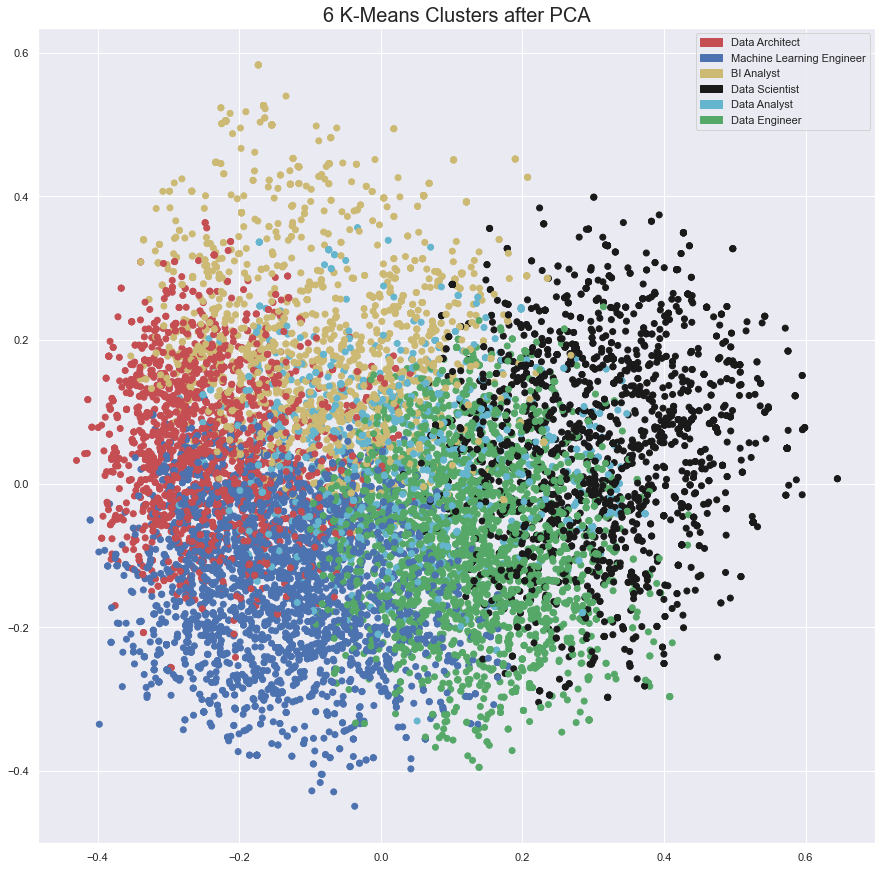

In [61]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(x_axis, y_axis, c=[colors[d] for d in kmean_indices])
clust0 = mpatches.Patch(color="r", label="Data Architect")
clust1 = mpatches.Patch(color="b", label="Machine Learning Engineer")
clust2 = mpatches.Patch(color="y", label="BI Analyst")
clust3 = mpatches.Patch(color="k", label="Data Scientist")
clust4 = mpatches.Patch(color="c", label="Data Analyst")
clust5 = mpatches.Patch(color="g", label="Data Engineer")
plt.legend(handles=[clust0, clust1, clust2, clust3, clust4, clust5])
plt.title("6 K-Means Clusters after PCA", fontsize=20)
plt.savefig("Images/6_KMeansClustersAfterPCA.png")


In [62]:
sample_df["kmeans_cluster"] = kmean_indices


In [63]:
job_category_dict = {
    0: "Data Architect",
    1: "Machine Learning Engineer",
    2: "BI Analyst",
    3: "Data Scientist",
    4: "Data Analyst",
    5: "Data Engineer",
}
sample_df = sample_df.replace({"kmeans_cluster": job_category_dict})


In [64]:
job_category_dict = {
    "Machine Learning Engineer": "Machine Learning Engineer",
    "Data Architect": "Data Architect",
    "Data Scientist": "Data Scientist",
    "Data Analyst": "Analyst",
    "Data Engineer": "Data Engineer",
    "Business Intelligence Analyst": "Analyst",
}
sample_df["combined_job_category"] = sample_df["job_category"].map(job_category_dict)


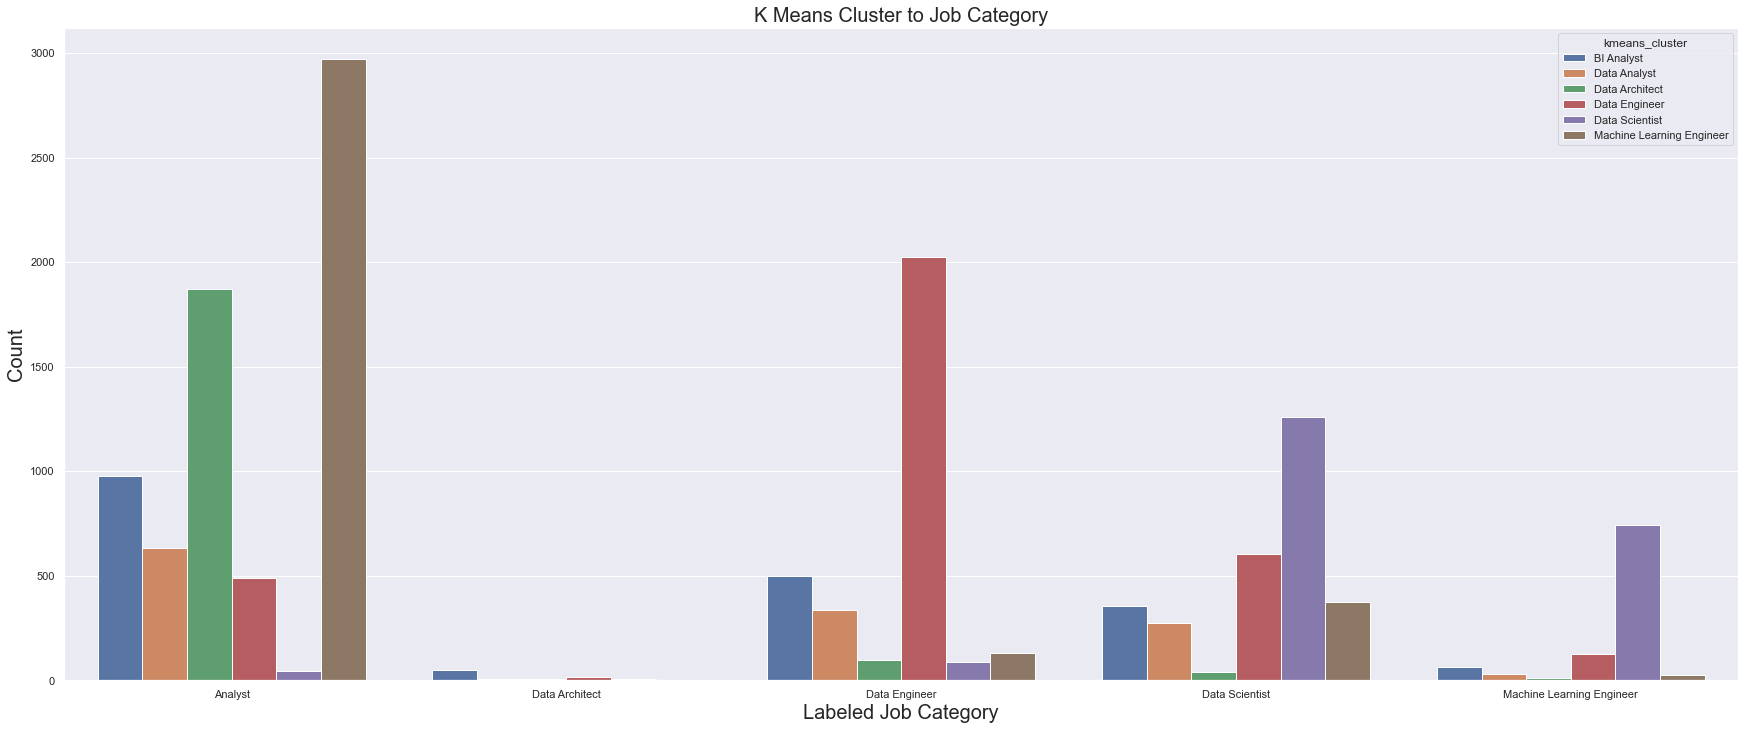

In [65]:
salary_by_job_state_mean = (
    sample_df.loc[:, ["kmeans_cluster", "combined_job_category", "job_title"]]
    .groupby(["combined_job_category", "kmeans_cluster"])["job_title"]
    .count()
    .reset_index()
)
sns.set(rc={"figure.figsize": (30, 12)})
ax = sns.barplot(
    x="combined_job_category",
    y="job_title",
    hue="kmeans_cluster",
    data=salary_by_job_state_mean,
)
plt.title("K Means Cluster to Job Category", fontsize=20)
plt.xlabel("Labeled Job Category", fontsize=20)
plt.ylabel("Count", fontsize=20)
plt.savefig("Images/KMeansClustertoJobCategory.png")


# Takeaways

- Salaries tend to be similar to each other within job descriptions
- Higher paid job titles: data architect, machine learning engineer, data scientist
- Ratings from glassdoor tend to be high across different categories with few exceptions
- Results of the NLP analyses seem to show natural similarities between certain job titles based on their job descriptions
